# Redistributing smart pools BAL rewards
This is a post processing script that redistributes BAL rewards allocated to controllers of smart pools to the actual share holders of said controllers. It requires that liquidity mining script for the week have been run and block by block reports be stored in the reports directory. It also requires access to a view in Google BigQuery that provides running balances for a subset of ERC20 tokens and holders.

In [1]:
import os
import json
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
from web3 import Web3
import matplotlib.pyplot as plt


WEEK = 20
WEEK_REPORTS_PATH = '../reports/' + str(WEEK)

Consider installing rusty-rlp to improve pyrlp performance with a rust based backend


In [2]:
# get receivers to redistribute
redistributers_dict = json.load(open('redistribute.json'))
redistributers_list = list(redistributers_dict.keys())

In [3]:
# get snapshot rewards
files = os.listdir(WEEK_REPORTS_PATH)
snapshot_files = [f for f in files if '_' not in f]
rewards_to_redistribute = {}
for f in snapshot_files:
    # filter snapshot rewards
    receiver_rewards = json.load(open(WEEK_REPORTS_PATH + '/' + f))[1]
    redistributers_rewards = dict(filter(lambda key_value: key_value[0] in redistributers_list, receiver_rewards.items()))
    rewards_to_redistribute[f[:f.find('.')]] = redistributers_rewards

In [4]:
rewards_to_redistribute_df = pd.DataFrame(rewards_to_redistribute)
rewards_to_redistribute_df.index.name = 'redistributer'
rewards_to_redistribute_df.columns.name = 'block_number'
rewards_to_redistribute_df = rewards_to_redistribute_df.melt(ignore_index=False)
rewards_to_redistribute_df.reset_index(inplace=True)
rewards_to_redistribute_df['redistributer'] = rewards_to_redistribute_df['redistributer'].apply(lambda x: x.lower())
rewards_to_redistribute_df['value'] = rewards_to_redistribute_df['value'].astype(float)
rewards_to_redistribute_df['block_number'] = rewards_to_redistribute_df['block_number'].astype(int)
rewards_to_redistribute_df

,redistributer,block_number,value
0,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11082770,0.219562
1,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11081234,0.245829
2,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11045138,0.201389
3,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11079954,0.255629
4,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11061522,0.223859
...,...,...,...
174,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11045394,0.201058
175,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11068690,0.229566
176,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11069202,0.230124
177,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,11039762,0.190690


In [5]:
# get redistributers' token holders
tokens = list(rewards_to_redistribute_df.redistributer.drop_duplicates())
snapshot_block_numbers = list(rewards_to_redistribute_df.block_number.drop_duplicates())
snapshot_block_numbers = [str(b) for b in snapshot_block_numbers]
sql = """
select * from `genuine-quasar-292419.ethereum_data.token_balances_subset`
where token_address in ({})
and block_number in ({})
and balance <> 0
""".format('\''+'\',\''.join(tokens)+'\'', 
           ','.join(snapshot_block_numbers))
print(sql)


select * from `genuine-quasar-292419.ethereum_data.token_balances_subset`
where token_address in ('0x49f2beff98ce62999792ec98d0ee4ad790e7786f')
and block_number in (11082770,11081234,11045138,11079954,11061522,11057938,11079186,11044882,11071762,11055378,11069714,11053330,11050770,11055122,11066642,11058194,11070738,11058706,11053074,11081490,11038994,11061778,11040530,11057426,11049746,11065106,11060754,11072786,11063314,11064594,11077906,11077394,11075346,11043346,11047186,11054354,11056914,11059474,11044114,11052306,11059730,11047954,11079698,11073554,11078162,11049490,11081746,11068178,11037714,11049234,11059218,11051794,11075858,11063826,11060498,11043602,11061266,11076370,11074834,11082258,11041042,11054610,11043090,11053842,11065618,11070226,11065874,11057682,11073298,11050002,11066130,11045650,11039506,11050258,11061010,11070482,11054098,11052818,11054866,11040274,11075090,11047698,11071250,11040018,11073810,11042834,11044626,11075602,11046162,11043858,11082002,11038482,110786

In [6]:
# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 
# with access to the token_balances_subset view

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
running_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
running_balances['balance'] = running_balances['balance'].astype(float)
running_balances = running_balances.rename(columns={"token_address": "redistributer", "address": "share_holder"})
running_balances.set_index(['block_number','redistributer','share_holder'], inplace=True)
running_balances

,,,balance
block_number,redistributer,share_holder,
11058962,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x045b947e655b4ae46965223851cc7f922d1d19bc,1.514336e+19
11059218,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x045b947e655b4ae46965223851cc7f922d1d19bc,1.514336e+19
11059474,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x045b947e655b4ae46965223851cc7f922d1d19bc,1.514336e+19
11059730,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x045b947e655b4ae46965223851cc7f922d1d19bc,1.514336e+19
11059986,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0x045b947e655b4ae46965223851cc7f922d1d19bc,1.514336e+19
...,...,...,...
11082002,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0xfe667f5bb242473bfa5e1eaf305703f2322795cf,3.634367e+22
11082258,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0xfe667f5bb242473bfa5e1eaf305703f2322795cf,3.634367e+22
11082514,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0xfe667f5bb242473bfa5e1eaf305703f2322795cf,3.634367e+22


In [7]:
shares = pd.DataFrame(running_balances['balance'])/pd.DataFrame(running_balances.groupby(['block_number','redistributer']).sum()['balance'])
shares.columns = ['perc_share']
shares.head()

perc_share
block_number redistributer                              share_holder                                          
11037458     0x49f2beff98ce62999792ec98d0ee4ad790e7786f 0x0a3cdf75aac28110b77b8a09f3f70427dfdc1738    0.000526
                                                        0x20074277f892404ee413753e01bac21a4f8d98c4    0.012587
                                                        0x22f35a1c13b291b72a771bb061078b80dcf3a6e6    0.002348
                                                        0x24d734a75166e66000c8d7f12a173e41358e3cc1    0.010468
                                                        0x2c639168530202a80c7693cfc0c758b61766851c    0.000987

In [8]:
rewards_to_redistribute_df.set_index(['block_number', 'redistributer'], inplace=True)
rewards_to_redistribute_df.fillna(0, inplace=True)
rewards_to_redistribute_df.head()

,,value
block_number,redistributer,
11082770,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.219562
11081234,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.245829
11045138,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.201389
11079954,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.255629
11061522,0x49f2beff98ce62999792ec98d0ee4ad790e7786f,0.223859


In [9]:
redistribution_df = pd.DataFrame(rewards_to_redistribute_df['value']*shares['perc_share']).dropna().reset_index()
redistribution_df.rename(columns={0: 'reward'}, inplace=True)
redistribution_df['share_holder'] = redistribution_df['share_holder'].apply(Web3.toChecksumAddress)
redistribution_df['redistributer'] = redistribution_df['redistributer'].apply(Web3.toChecksumAddress)

In [10]:
redistribution_df

,block_number,redistributer,share_holder,reward
0,11037458,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x0a3cdf75aAc28110B77B8a09f3F70427dfDC1738,0.000104
1,11037458,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x20074277f892404Ee413753e01bac21A4f8D98c4,0.002491
2,11037458,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x22F35A1c13b291B72A771bb061078B80dCf3A6E6,0.000465
3,11037458,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x24d734a75166e66000C8d7f12A173e41358e3cc1,0.002072
4,11037458,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0x2C639168530202a80C7693cfC0c758b61766851C,0.000195
...,...,...,...,...
8303,11083026,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xeB0020f885535323fc8dCa7b8b8896680Ce6B0d7,0.003701
8304,11083026,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xeF8305E140ac520225DAf050e2f71d5fBcC543e7,0.000058
8305,11083026,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xf9FA4901b4Cb295D12db7662079e2a8DeDDdCE08,0.000141
8306,11083026,0x49F2befF98cE62999792Ec98D0eE4Ad790E7786F,0xfC6EDEB989187ff13396450d5fB6eFc4860dB1f4,0.000217


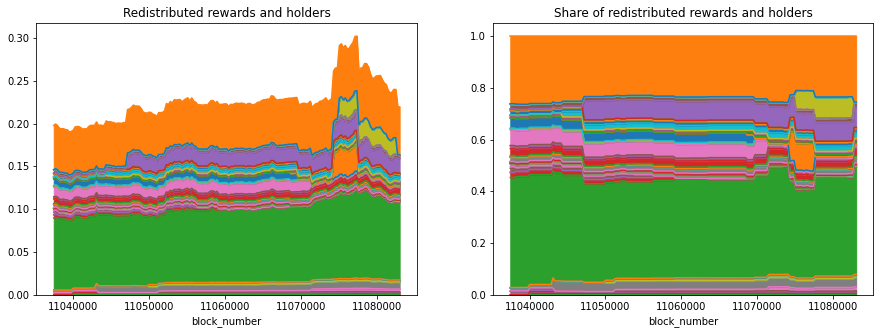

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

areaplot = redistribution_df.pivot(index='block_number', columns='share_holder', values='reward')
areaplot.plot.area(legend=False, ax=axs[0],
                   title='Redistributed rewards and holders');
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(legend=False, ax=axs[1],
                                                        title='Share of redistributed rewards and holders');
axs.flat[0].ticklabel_format(axis='x', style='plain')
axs.flat[1].ticklabel_format(axis='x', style='plain')

In [12]:
total_redistribution = redistribution_df.groupby('share_holder').sum()['reward']
total_redistribution

share_holder
0x045B947E655b4AE46965223851CC7F922d1D19bc    0.002225
0x0a3cdf75aAc28110B77B8a09f3F70427dfDC1738    0.019382
0x0d307D9C8B6D4aaD162A662E4bbFbA9Ea96A5F81    0.024721
0x130608072C043CF1a5f3d0003Da1db23D6F56Ad2    0.420355
0x20074277f892404Ee413753e01bac21A4f8D98c4    0.056540
                                                ...   
0xf64C742EdDe8a10751616E48E406188A02E9A9e4    0.001333
0xf7814b5CECf31907745420d67D52D1c8b1671541    0.616055
0xf9FA4901b4Cb295D12db7662079e2a8DeDDdCE08    0.024266
0xfC6EDEB989187ff13396450d5fB6eFc4860dB1f4    0.037401
0xfe667F5bb242473BfA5E1EAF305703f2322795cF    9.623495
Name: reward, Length: 62, dtype: float64

In [13]:
total_pre_redistribution = json.load(open(WEEK_REPORTS_PATH + '/_totals.json'))
total_post_redistribution = total_pre_redistribution.copy()
for index,value in total_redistribution.iteritems():
    old_value = float(total_pre_redistribution.get(index,0))
    new_value = old_value + value
    total_post_redistribution[index] = format(new_value, '.18f')

for r in redistribution_df['redistributer'].drop_duplicates():
    del total_post_redistribution[r]

In [14]:
print('BAL  pre-redistribution: {:.18f}'.format(sum([float(v) for v in total_pre_redistribution.values()])))
print('BAL post-redistribution: {:.18f}'.format(sum([float(v) for v in total_post_redistribution.values()])))

BAL  pre-redistribution: 144997.770157749648205936
BAL post-redistribution: 144997.770157749677309766


In [15]:
json.dump(total_pre_redistribution, 
          open(WEEK_REPORTS_PATH + '/_totalsPreRedistribute.json', mode='w'),
          indent=4)

In [16]:
json.dump(total_post_redistribution, 
          open(WEEK_REPORTS_PATH + '/_totals.json', mode='w'),
          indent=4)